In [1]:
from mongodbcredentials import CONNECTION_STRING
from pymongo import MongoClient
import certifi
import pandas as pd
from twitter_modules import database_as_tweet, database_as_bert, positive_neg_count_df, plot_topics

In [2]:
client = MongoClient(CONNECTION_STRING, tlsCAFile=certifi.where())

In [3]:
twitter_facemasks = client.TwitterFacemasks
twitter_lockdown = client.TwitterLockdown
twitter_pcr = client.TwitterPCR
twitter_pfizer = client.TwitterPfizer
twitter_quarantine = client.TwitterQuarantine
twitter_restrictions = client.TwitterRestrictions
twitter_vaccine = client.TwitterVaccination

In [4]:
facemasks_dict = database_as_tweet(twitter_facemasks)
lockdown_dict = database_as_tweet(twitter_lockdown)
pcr_dict = database_as_tweet(twitter_pcr)
pfizer_dict = database_as_tweet(twitter_pfizer)
quarantine_dict = database_as_tweet(twitter_quarantine)
restrictions_dict = database_as_tweet(twitter_restrictions)
vaccine_dict = database_as_tweet(twitter_vaccine)


In [5]:
facemasks_df = pd.DataFrame(facemasks_dict, columns=['tweet'])
lockdown_df = pd.DataFrame(lockdown_dict, columns=['tweet'])
pcr_df = pd.DataFrame(pcr_dict, columns=['tweet'])
pfizer_df = pd.DataFrame(pfizer_dict, columns=['tweet'])
quarantine_df = pd.DataFrame(quarantine_dict, columns=['tweet'])
restrictions_df = pd.DataFrame(restrictions_dict, columns=['tweet'])
vaccine_df = pd.DataFrame(vaccine_dict, columns=['tweet'])

In [6]:
facemask_sentiment = facemasks_df.apply(database_as_bert, axis=1)

In [7]:
lockdown_sentiment = lockdown_df.apply(database_as_bert, axis=1)

In [8]:
pcr_sentiment = pcr_df.apply(database_as_bert, axis=1)

In [9]:
pfizer_sentiment = pfizer_df.apply(database_as_bert, axis=1)

In [10]:
quarantine_sentiment = quarantine_df.apply(database_as_bert, axis=1)

In [11]:
restrictions_sentiment = restrictions_df.apply(database_as_bert, axis=1)

In [12]:
vaccine_sentiment = vaccine_df.apply(database_as_bert, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


In [13]:
facemasks_sentiment = positive_neg_count_df(facemask_sentiment)
lockdown_sentiment = positive_neg_count_df(lockdown_sentiment)
pcr_sentiment = positive_neg_count_df(pcr_sentiment)
pfizer_sentiment = positive_neg_count_df(pfizer_sentiment)
quarantine_sentiment = positive_neg_count_df(quarantine_sentiment)
restrictions_sentiment = positive_neg_count_df(restrictions_sentiment)
vaccine_sentiment = positive_neg_count_df(vaccine_sentiment)

In [14]:
list_of_topics = ['Facemasks', 'Lockdown', 'PCR', 'Pfizer', 'Quarantine', 'Restrictions', 'Vaccine']

In [15]:
query_dpts = []
positive = []
negative = []
neutral = []

for sentiment in facemasks_sentiment, lockdown_sentiment, pcr_sentiment, \
    pfizer_sentiment, quarantine_sentiment, restrictions_sentiment, vaccine_sentiment:
    positive += [sentiment['pos_perc']]
    negative += [sentiment['neg_perc']]
    neutral += [sentiment['neu_perc']]

query_dpts += [positive, negative, neutral]

<Figure size 432x288 with 0 Axes>

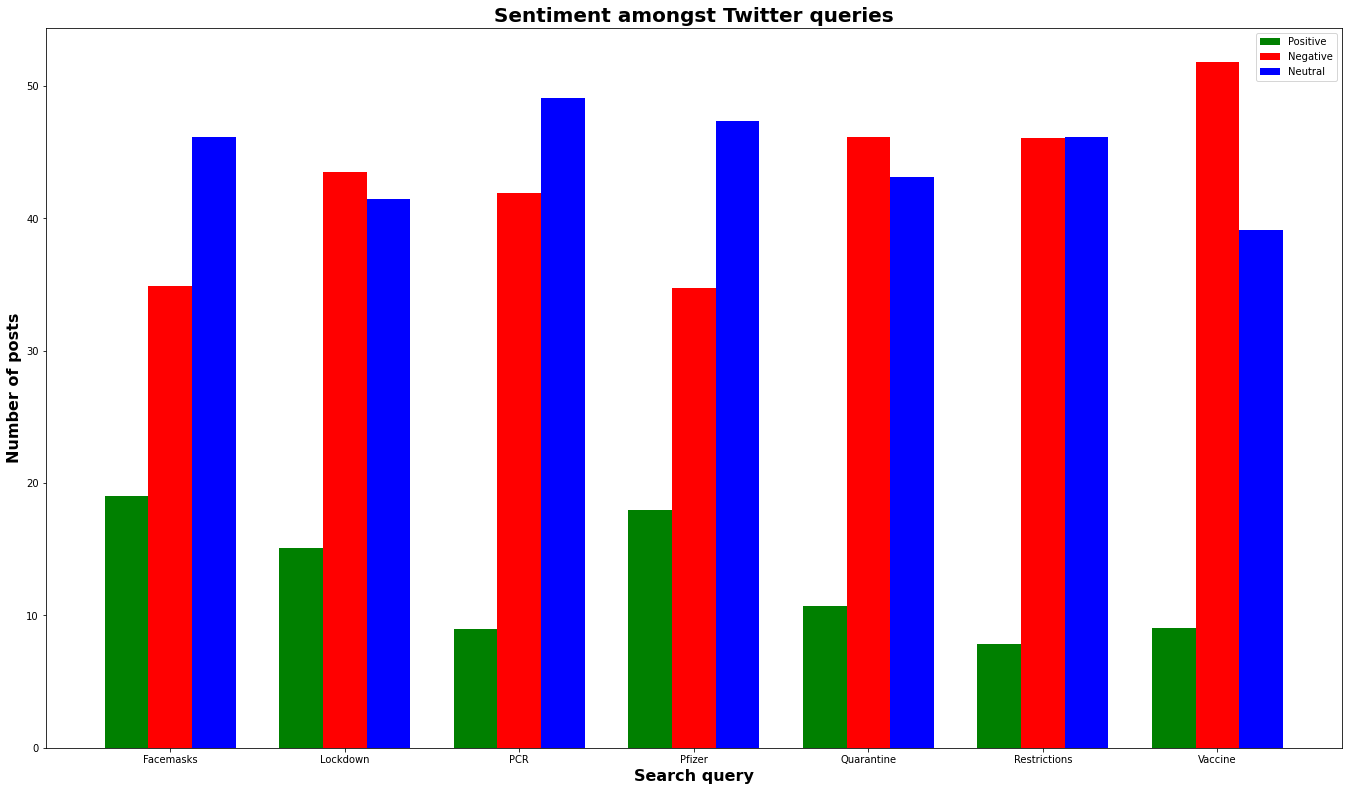

In [16]:
plot_topics(list_of_topics, query_dpts)